# Setup

## Imports

In [1]:
import os.path
import librosa
import librosa.display
import itertools

from IPython import display
from glob import glob
from time import time, sleep
from tqdm import tqdm_notebook as tqdm
from concurrent.futures import ThreadPoolExecutor
from scipy.io import wavfile

vai Modules

In [2]:
from vai_.io import pickle_dump, pickle_load
from vai_.torch.stats import ModelStats
from vai.plot import smooth_plot as _smooth_plot

Torch Modules

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.autograd import Variable

In [4]:
from utils import hparams
from utils.wavenet_vocoder.audio import _denormalize

## Define Useful Features

In [5]:
DIR_DATA = DIR_DATA['LJSpeech']

In [6]:
cuda = lambda x: x.cuda() if hparams.use_gpu and torch.cuda.is_available() else x

In [7]:
normalize = lambda x: (x - spec_mean) / spec_std

In [8]:
denormalize = lambda x: _denormalize(x * spec_std + spec_mean)

In [9]:
def plot_spectrogram(spectrogram):
    librosa.display.specshow(denormalize(spectrogram), sr=hparams.sample_rate,
                             hop_length=hparams.hop_length, x_axis='time', y_axis='mel')
    plt.title('Mel spectrogram')
    plt.colorbar(format='%+2.0f dB')
    plt.set_cmap('viridis')
    plt.show()

In [10]:
def load_model():
    global model, history, stats, optimizer
    if not os.path.exists(os.path.join(DIR_CHECKPOINTS, 'model.pt')): return
    model.load_state_dict(torch.load(os.path.join(DIR_CHECKPOINTS, 'model.pt')))
    optimizer.load_state_dict(torch.load(os.path.join(DIR_CHECKPOINTS, 'optimizer.pt')))
    
    history = pickle_load(os.path.join(DIR_CHECKPOINTS, 'history.p'))
    stats.load(os.path.join(DIR_CHECKPOINTS, 'stats.p'))

In [11]:
def _save_model(path=DIR_CHECKPOINTS):
    torch.save(model.state_dict(), os.path.join(path, 'model.pt'))
    torch.save(optimizer.state_dict(), os.path.join(path, 'optimizer.pt'))
    pickle_dump(os.path.join(path, 'history.p'), history)
    stats.save(os.path.join(path, 'stats.p'))

In [12]:
def save_model():
    _save_model()
    
    if history['post_loss'][-1]  < 1.01 * min(history['post_loss']):
        _save_model(os.path.join(DIR_CHECKPOINTS, '.best'))

In [13]:
def smooth_plot(*args, **kwargs):
    plot(*args, **kwargs)
    _smooth_plot(*args, **kwargs)

In [14]:
def _diagonality(x):
    r, c = x.shape
    row_ids = (np.arange(c)*r/c).astype(np.int)
    return x[row_ids, np.arange(c)].sum() / x.sum()

## Checks

In [15]:
if hparams.train_files >= 0:
    assert hparams.train_files >= hparams.batch_size

In [16]:
assert os.path.exists(os.path.join(DIR_DATA, 'preprocess'))

## Load Data

### Load Files and Metadata

In [17]:
filenames = sorted(glob(os.path.join(DIR_DATA, 'preprocess', '*.npz')))

In [18]:
spec_mean, spec_std = np.load(os.path.join(DIR_DATA, 'preprocess', 'stats.npy'))
spec_mean = np.expand_dims(spec_mean, -1)
spec_std = np.expand_dims(spec_std, -1)

In [19]:
tokenizer = pickle_load(os.path.join(DIR_DATA, 'preprocess', 'tokenizer.p'))

Using TensorFlow backend.


In [20]:
char_idx = tokenizer.word_index
idx_char = {v: k for k, v in char_idx.items()}
vocab_size = len(char_idx)

### Reduce to training and validation datasets

In [21]:
if hparams.train_files < 0: hparams.train_files = len(filenames)
filenames_train = filenames[:hparams.train_files]

In [22]:
val_files = int(hparams.train_files * hparams.val_split)
filenames_val = filenames[:val_files]

### Generator

In [23]:
def pad_tensor(x, dim, size):
    if x.shape[dim] >= size: return x
    
    pad_width = np.zeros((len(x.shape), 2), dtype=np.int)
    pad_width[dim] = (0, size - x.shape[dim])
    return np.pad(x, pad_width, mode='constant')

In [24]:
def zero_tensor(x, dim, sizes):
    assert len(sizes) == len(x)
    if len(sizes) == 1: return x
    if dim < 0: dim += len(x.shape)
    
    indices = torch.ones_like(x)
    for i, size in enumerate(sizes):
        high = indices[i].size(dim-1)
        if high <= size: continue
        
        if dim == 1: indices[i, size:high] = 0
        elif dim == 2: indices[i, :, size:high] = 0
        else: raise ValueError('something wrong with dim in zero_tensor')
    
    return x * indices

In [25]:
def _get_data(train, file_idx):
    fnames = filenames_train if train else filenames_val
    file_idx = np.random.randint(len(fnames))
        
    x = np.load(fnames[file_idx])

    transcript, spectrogram = x['transcript'], x['spectrogram']
    stop_probs = np.linspace(0, 1, spectrogram.shape[1], dtype=np.float32)

    return transcript, normalize(spectrogram), stop_probs

In [26]:
def data_generator(train=True, num_workers=4, shuffle=True):
    bs = hparams.batch_size if train else 1
    fnames = filenames_train if train else filenames_val
    
    while True:
        indices = np.random.permutation(np.arange(len(fnames))) if shuffle else np.arange(len(fnames))
        for start_idx in range(0, len(indices), bs):
            transcripts, spectrograms, stop_probs = [], [], []
            transcripts_len, spectrograms_len = [], []

            with ThreadPoolExecutor(num_workers) as executor:
                res = executor.map(_get_data, [train]*bs,indices[start_idx:min(len(indices), start_idx + bs)],)

            res = list(res)
            transcripts = [r[0] for r in res]
            spectrograms = [r[1] for r in res]
            stop_probs = [r[2] for r in res]

            transcripts_len = [len(transcript) for transcript in transcripts]
            spectrograms_len = [spectrogram.shape[1] for spectrogram in spectrograms]           
            max_transcript_len = max(transcripts_len)
            max_spectrograms_len = max(spectrograms_len)

            transcripts = np.stack(pad_tensor(t, 0, max_transcript_len) for t in transcripts)
            spectrograms = np.stack(pad_tensor(s, 1, max_spectrograms_len) for s in spectrograms)
            stop_probs = np.stack(pad_tensor(s, 0, max_spectrograms_len) for s in stop_probs)

            yield((Variable(cuda(torch.from_numpy(transcripts))), transcripts_len),
            (Variable(cuda(torch.from_numpy(spectrograms))), spectrograms_len),
            Variable(cuda(torch.from_numpy(stop_probs))))

In [27]:
batches_per_epoch = len(filenames_train) // hparams.batch_size

# Create Model

## TODOs

<font color=red>
Fix BiLSTM
    
Add Regularization

Make initial states of Encoder and Decoder as params

Add Relu to Attention alpha-conv

Make initial attention context after lstm in decoder

In attention, does the long time recurrence of the self.last_attn cause backprop issues?

## Regularized Layers

In [28]:
printer = lambda verbosity: print if verbosity > 0 else lambda *args: None

In [29]:
class Conv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0,
                 dilation=1, groups=1, bias=True):
        super().__init__()
        conv = nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride,
                              padding=padding, dilation=dilation,
                              groups=groups, bias=bias)
        dropout = nn.Dropout(p=hparams.p_dropout)
        self.net = nn.Sequential(conv, dropout)
        
    def forward(self, x):
        return self.net(x)

In [30]:
class PreNetLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        fc = nn.Linear(in_features, out_features, bias=bias)
        dropout = nn.Dropout(p=hparams.p_dropout)
        self.net = nn.Sequential(fc, dropout)
        
    def forward(self, x):
        return self.net(x)

In [31]:
def zoneout(x, x_prev, p, train):
    if not train: return x
    
    retain_mask = Variable(cuda(torch.rand(x.size()).le(p).float()))
    
    return retain_mask * x_prev + (1 - retain_mask) * x

In [32]:
class LSTM(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.lstm = nn.LSTM(*args, **kwargs)
        
        self.lstm.num_directions = 2 if self.lstm.bidirectional else 1
        
    def forward(self, x, hx=None, verbosity=0):
        _print = printer(verbosity)
        _print('before transpose, x', x.size())
        iterator =  torch.transpose(x, 0, 1) if self.lstm.batch_first else x
        _print('after transpose, iterator', iterator.size())
        seq_len, batches = iterator.shape[:2]
        _print('unpack, seq_len, batches', seq_len, batches)
        outputs = Variable(cuda(torch.zeros(seq_len, batches, self.lstm.hidden_size * self.lstm.num_directions)))
        outputs = torch.transpose(outputs, 0, 1) if self.lstm.batch_first else outputs
        _print('outputs', outputs.size())
        
        if hx is None:
            h_prev = Variable(cuda(torch.zeros(self.lstm.num_layers * self.lstm.num_directions, batches, self.lstm.hidden_size)))
            c_prev = Variable(cuda(torch.zeros(self.lstm.num_layers * self.lstm.num_directions, batches, self.lstm.hidden_size)))
        else:
            h_prev, c_prev = hx
        _print('h_prev, c_prev', h_prev.size(), c_prev.size())
        
        _print = printer(verbosity - 1)
        for i, x_i in enumerate(iterator):
            _print('\nAt iteration', i)
            expand_dim = 1 if self.lstm.batch_first else 0
            x_i = x_i.unsqueeze(expand_dim)
            _print('before lstm, x_i', x_i.size())
            output, (h, c) = self.lstm(x_i, (h_prev, c_prev))
            _print('after lstm, output, h_prev, c_prev', output.size(), h_prev.size(), c_prev.size())
            if self.lstm.batch_first:
                outputs[:, i] = output.squeeze(expand_dim)
            else:
                outputs[i] = output.squeeze(expand_dim)
            
            # Magic
            h_prev = zoneout(h, h_prev, hparams.p_zoneout, self.training)       
            c_prev = zoneout(c, c_prev, hparams.p_zoneout, self.training)
            
            _print('After zoneout, h_prev, c_prev', h_prev.size(), c_prev.size())
            
        return outputs, (h_prev, c_prev)

## Encoder

In [33]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size + 1, hparams.embedding_dim, padding_idx=0)
        
        self.conv = nn.ModuleList([Conv(hparams.embedding_dim, hparams.encoder_conv_filters,
                                             hparams.encoder_conv_len, padding=2, bias=True)])
        self.conv.extend([Conv(hparams.encoder_conv_filters, hparams.encoder_conv_filters,
                                    hparams.encoder_conv_len, padding=2, bias=True)
                          for _ in range(hparams.encoder_num_conv - 1)])
        
        self.bn = nn.ModuleList([nn.BatchNorm1d(hparams.encoder_conv_filters)
                                 for _ in range(hparams.encoder_num_conv)])
        
        self.lstm = LSTM(input_size=hparams.encoder_conv_filters,
                         hidden_size=hparams.encoder_lstm_hidden,num_layers=1, batch_first=True,
                         bidirectional=True)
    
    def forward(self, x, verbose=0):
        x, seq_sizes = x
        _print = printer(verbose)
        
        _print('in', x.size())
        x = torch.transpose(self.embedding(x), 1, 2)
        _print('embed', x.size())
        
        _print = printer(verbose - 1)
        _print('\nEntering conv net')
        for i, (bn, conv) in enumerate(zip(self.bn, self.conv)):
            x = F.relu(bn(conv(x)))
            _print('After iteration', i, x.size())
        _print = printer(verbose)
        
        x = torch.transpose(x, 1, 2)

        x = self.lstm(x)[0]
        x = zero_tensor(x, 1, seq_sizes)
        _print('\nafter lstm', x.size())
        return x, seq_sizes

## Attention

In [34]:
class Attention(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc_s = nn.Linear(hparams.decoder_lstm_hidden, hparams.attn_hidden, bias=True)
        self.fc_h = nn.Linear(hparams.encoder_lstm_hidden * 2, hparams.attn_hidden, bias=True)
        self.conv = Conv(1, hparams.attn_conv_filters, hparams.attn_conv_len,
                              padding=(hparams.attn_conv_len - 1) // 2, bias=True)
        self.fc_conv = nn.Linear(hparams.attn_conv_filters, hparams.attn_hidden, bias=True)
        self.fc = nn.Linear(128, 1, bias=True)
    
    def forward(self, s, verbose=0):
        _print = printer(verbose)
            
        _print('s', s.size())
        s = self.fc_s(s)
        _print('After fc_s, s', s.size())
        
        _print('Before conv, self.last_attn', self.last_attn.size())
        convs = self.conv(self.last_attn)
        _print('After conv(self.last_attn), convs', convs.size())
        convs = torch.transpose(convs, 1, 2)
        _print('After transpose, convs', convs.size())
        convs = self.fc_conv(convs)
        _print('After self.fc_conv, convs', convs.size())
        
        scores = F.tanh(s + self.hs + convs)
        scores = self.fc(scores)

        self.last_attn = F.softmax(scores, dim=1)
        self.last_attn = zero_tensor(self.last_attn, 1, self.seq_sizes)
        _print('After softmax, self.last_attn', self.last_attn.size())
        
        
        _print('Before mul, self.last_attn', self.last_attn.size(),
              ', self.encoder_hidden', self.encoder_hidden.size())
        context = (self.last_attn * self.encoder_hidden).sum(1)
        _print('After mul, context', context.size())
        
        self.last_attn = self.last_attn.transpose(1, 2).detach()
        _print('Transpose, self.last_attn', self.last_attn.size())

        return context
    
    def reset(self, encoder_hidden, verbose=0):
        _print = printer(verbose)
        _print('\nResetting attention\n')
        
        encoder_hidden, self.seq_sizes = encoder_hidden
        self.encoder_hidden = encoder_hidden
        self.last_attn = Variable(cuda(torch.zeros(*encoder_hidden.size()[:-1]).unsqueeze(1)))
        self.last_attn[:, :, 0] = 1
        self._initialize(verbose - 1)
        _print('Reseting, self.encoder_hidden', self.encoder_hidden.size(),
             'self.last_attn', self.last_attn.size(), '\n\n')
        
    def _initialize(self, verbose=0):
        _print = printer(verbose)
        _print('\nInitializing h for the first time\n')
        _print('Before fc_h, self.encoder_hidden', self.encoder_hidden.size())
        self.hs = self.fc_h(self.encoder_hidden)
        _print('After fc_h, self.hs', self.hs.size())
        _print('\n\n')
        
    def _find_median(self):
        x = self.last_attn[0].data
        
        indices_nonzero = torch.nonzero(x)
        if len(indices_nonzero) == 0:
            return 0, attn_window_len + 1
        x = x[indices_nonzero[:, 0]]
        indices = torch.sort(x)[1]
        indices = indices_nonzero[indices]
        idx = (len(x) + 1) // 2
        idx = indices[idx]
        start_idx = idx - (attn_window_len + 1)//2
        if start_idx[0] < 0:
            return 0, attn_window_len + 1
        
        end_idx = idx + (attn_window_len + 1)//2
        return start_idx[0], end_idx[0]

## Decoder

In [35]:
class Decoder(nn.Module):
    def __init__(self, attention):
        super().__init__()     
        self.attention = attention
        
        self.pre_net = nn.ModuleList([PreNetLinear(hparams.num_mels, hparams.decoder_pre_hidden)])
        self.pre_net.extend([PreNetLinear(hparams.decoder_pre_hidden, hparams.decoder_pre_hidden)
                            for _ in range(hparams.decoder_num_pre - 1)])
        
        self.lstm = LSTM(input_size=hparams.decoder_pre_hidden + hparams.encoder_lstm_hidden * 2,
                            hidden_size=hparams.decoder_lstm_hidden, num_layers=hparams.decoder_num_lstm,
                            batch_first=True)
        self.fc = nn.Linear(hparams.decoder_lstm_hidden + hparams.encoder_lstm_hidden * 2,
                            hparams.num_mels)
        self.fc_stop = nn.Linear(hparams.decoder_lstm_hidden + hparams.encoder_lstm_hidden * 2,
                                 1, bias=True)
        
        self.post_net = nn.ModuleList([nn.Conv1d(hparams.num_mels, hparams.decoder_conv_filters,
                                                 hparams.decoder_conv_len,
                                                 padding=hparams.decoder_conv_len // 2, bias=True)])
        self.post_net.extend([Conv(hparams.decoder_conv_filters, hparams.decoder_conv_filters,
                                                 hparams.decoder_conv_len,
                                                 padding=hparams.decoder_conv_len // 2, bias=True)
                                      for _ in range(hparams.decoder_num_conv - 2)])
        self.final_post_net = Conv(hparams.decoder_conv_filters, hparams.num_mels,
                                        hparams.decoder_conv_len,
                                        padding=hparams.decoder_conv_len // 2, bias=True)
        self.bn = nn.ModuleList([nn.BatchNorm1d(hparams.decoder_conv_filters)
                                 for _ in range(hparams.decoder_num_conv - 1)])
        self.teacher_prob = nn.Parameter(torch.ones(1), requires_grad=False)
        
    def forward(self, encoder_hidden, spectrogram, max_len, stop_threshold, verbose):
        _print = printer(verbose)
        stop_threshold = -np.log(1 / stop_threshold - 1)
        
        teacher_force = True
        if self.training:
            if spectrogram is None:
                raise ValueError('Feed spectrogram while training.')
        else:
            if spectrogram is None:
                spectrogram = Variable(cuda(torch.zeros(1, hparams.num_mels, max_len))), [1]
                teacher_force = False
        
        spectrogram, seq_sizes = spectrogram
        encoder_hidden, trans_sizes = encoder_hidden
        
        last_pred = Variable(cuda(torch.zeros(encoder_hidden.size(0), hparams.num_mels)))
        prev_hidden = Variable(cuda(torch.zeros(hparams.decoder_num_lstm, encoder_hidden.size(0), hparams.decoder_lstm_hidden)))
        prev_cell = Variable(cuda(torch.zeros(hparams.decoder_num_lstm, encoder_hidden.size(0), hparams.decoder_lstm_hidden)))
        
        spectrogram = spectrogram.transpose(0, 1).transpose(0, -1)
        stop_probs = Variable(cuda(torch.zeros(spectrogram.size()[:-1])))
        pre_predictions = Variable(cuda(torch.zeros(spectrogram.size())))
        
        _print('Sizes: last_pred', last_pred.size(), ', prev_hidden', prev_hidden.size(),
               ', prev_cell', prev_cell.size(), ', spectrogram', spectrogram.size(),
              ', stop_probs', stop_probs.size(), ', pre_predictions', pre_predictions.size())

        self.attention.reset((encoder_hidden, trans_sizes), verbose - 4)
        attn_probs = []
        _print = printer(verbose - 1)
        for i, correct_pred in enumerate(spectrogram):
            _print('At iteration', i)
            pre_out = last_pred

            _print = printer(verbose - 2)
            _print('Entering pre_net loop')
            for j, pre_net in enumerate(self.pre_net):
                _print('Before pre_net[', j, '], pre_out', pre_out.size())
                pre_out = F.relu(pre_net(pre_out))
                _print('After pre_net[', j, '], pre_out', pre_out.size())
            _print = printer(verbose - 1)
            
            _print('Entering attention\n')
            attn_context = self.attention(torch.transpose(prev_hidden[-1:], 0, 1), verbose - 4)
            attn_probs.append(self.attention.last_attn.data.cpu().numpy())
            _print('After attn attn_context', attn_context.size())

            out = torch.unsqueeze(torch.cat([pre_out, attn_context], dim=-1), dim=1)
            _print('After concatenation [pre_out, attn_context], out', out.size())
            lstm_out, (prev_hidden, prev_cell) = self.lstm(out, (prev_hidden, prev_cell))
            _print('After lstm, lstm_out', lstm_out.size(), ', prev_hidden',
                 prev_hidden.size(), ', prev_cell', prev_cell.size())

            out = torch.cat([lstm_out.squeeze(1), attn_context], dim=-1)
            _print('After concatentaion [lstm_out, attn_context]', out.size())
            pre_preds = self.fc(out)
            _print('After fc, pre_preds', pre_preds.size())
            stop_probs[i] = self.fc_stop(out.detach())
            _print('After fc_stop, stop_probs[i]', stop_probs[i])
            out = torch.unsqueeze(pre_preds, -1)

            last_pred = self._draw(correct_pred, pre_preds.detach(), self.teacher_prob) if teacher_force else pre_preds
            pre_predictions[i] = pre_preds
            
            '''
            if teacher_force:
                continue
            elif stop_probs[i].data.cpu().numpy()[0] > stop_threshold:
                stop_probs = stop_probs[:i + 1]
                predictions = predictions[:i + 1]
                break
            '''

        _print = printer(verbose)
        pre_predictions = pre_predictions.transpose(0, 1).transpose(1, 2)
        _print('\n\nAfter loop, pre_predictions', pre_predictions.size())
        pre_predictions = zero_tensor(pre_predictions, -1, seq_sizes)

        _print = printer(verbose - 3)
        _print('Entering post_net loop')
        out = pre_predictions
        for i, (post_net, bn) in enumerate(zip(self.post_net, self.bn)):
            _print('Before', i, 'iteration of post_net, out', out.size())
            out = F.tanh(bn(post_net(out)))
            _print('After', i, 'iteration of post_net, out', out.size())
        out = self.final_post_net(out)
        _print('After last post_net, out', out.size())
        _print = printer(verbose)

        post_predictions = pre_predictions + torch.squeeze(out, dim=0)
        _print('After adding, post_predictions', post_predictions.size())
        post_predictions = zero_tensor(post_predictions, -1, seq_sizes)
        
        stop_probs = stop_probs.t()
        stop_probs = zero_tensor(stop_probs, -1, seq_sizes)
        
        return pre_predictions, post_predictions, stop_probs, np.vstack(attn_probs)
    
    def _draw(self, x, y, p_x):
        x_mask = torch.bernoulli(p_x)
        return x * x_mask + y * (1 - x_mask)

## Model

In [36]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder(Attention())
        
    def forward(self, transcript, spectrogram=None, **kwargs):
        max_len = kwargs.pop('max_len', 500)
        stop_threshold = kwargs.pop('stop_threshold', 0.9)
        verbosity = kwargs.pop('verbosity', 0)
        
        _print = printer(verbosity)
        _print('Entering encoder\n')
        encoder_hidden = self.encoder(transcript, verbosity - 10)
        
        _print('\nEntering decoder\n')
        decoded = self.decoder(encoder_hidden, spectrogram, max_len, stop_threshold,
                               verbosity - 20)
        return decoded

# Train

In [37]:
model = cuda(Model())
history = {'iterations': 0, 'running_iterations': [], 'time': [], 'pre_loss': [],
           'post_loss': [], 'stop_loss': [], 'val_pre_loss': [], 'val_post_loss': [],
           'val_stop_loss': [], 'val_attn_loss': [], 'lr': [], 'last_lr': hparams.lr_initial,
           'running_loss': {'pre': [], 'post': [], 'stop': []}}
stats = ModelStats(model, store_history=True)

/home/vaisakh/AI/.pyscripts/vai_/torch/stats.py:38: UserWarning: Storing unbounded history takes a lot of space.
Continue only if you are certain you have enough space.
  warnings.warn('Storing unbounded history takes a lot of space.\n'


In [38]:
params = [p for n, p in model.named_parameters() if p.requires_grad]
optimizer = optim.Adam(params, lr=hparams.lr_initial, eps=1e-6, weight_decay=hparams.weight_decay)

In [39]:
criterion_mse = nn.MSELoss()
criterion_bce = nn.BCEWithLogitsLoss()

In [40]:
def get_loss(gen, train=True):
    transcript, spectrogram, stop_tokens = next(gen)
    if not train:
        model.eval()
        pre_predictions, post_predictions, stop_probs, attn_probs = model(transcript, stop_threshold=1, max_len=spectrogram[0].shape[-1])
    else:
        model.train()
        pre_predictions, post_predictions, stop_probs, attn_probs = model(transcript, spectrogram)
    
    loss_dict = {}
    pre_loss = criterion_mse(pre_predictions, spectrogram[0])
    post_loss = criterion_mse(post_predictions, spectrogram[0])
    stop_loss = criterion_bce(stop_probs, stop_tokens)
    
    loss = pre_loss + stop_loss + post_loss
    
    loss_dict['pre'] = pre_loss.data.cpu().numpy()[0]
    loss_dict['post'] = post_loss.data.cpu().numpy()[0]
    loss_dict['stop'] = stop_loss.data.cpu().numpy()[0]
    if not train:
        loss_dict['attn'] = _diagonality(attn_probs[:, 0].T)
    return loss, loss_dict

In [41]:
teacher_prob_decay = 1 / (hparams.expected_convergence_epochs * batches_per_epoch)

In [42]:
def optimize(iterations=1, epochs=0, save_every=1):
    load_model()
    model.train()
    
    start_time = time()
    
    gen = data_generator()
    gen_val = data_generator(train=False)
    if epochs != 0: iterations = batches_per_epoch * epochs
    prog_bar = tqdm(range(history['iterations'], history['iterations'] + iterations))
    
    for iteration, start_idx in enumerate(prog_bar):
        optimizer.zero_grad()
        
        loss, loss_dict = get_loss(gen)
        
        loss.backward();
        optimizer.step()
        
        for k in loss_dict.keys(): history['running_loss'][k].append(loss_dict[k])

        if len(history['running_loss']['pre']) > batches_per_epoch:
            for k in loss_dict.keys(): history['running_loss'][k].pop(0)

        mean_loss = sum(history['running_loss']['post']) / len(history['running_loss']['post'])

        prog_bar.set_description('loss:{:.4f}'.format(mean_loss))

        history['iterations'] += 1
        if history['iterations'] > hparams.lr_decay_iterations:
            optimizer.param_groups[0]['lr'] *= lr_decay_rate
            optimizer.param_groups[0]['lr'] += lr_final * (1 - lr_decay_rate)
            history['last_lr'] = optimizer.param_groups[0]['lr']
            
        ## VV Important
        model.decoder.teacher_prob -= teacher_prob_decay

        if time() - start_time > save_every * 60 or iteration == len(prog_bar) - 1:
            history['running_iterations'].append(history['iterations'])
            history['time'].append(time())
            for k in loss_dict.keys():
                history[k + '_loss'].append(sum(history['running_loss'][k]) / len(history['running_loss'][k]))
            history['lr'].append(optimizer.param_groups[0]['lr'])
            
            if len(filenames_val) > 0:
                val_loss_dict = get_loss(gen_val, train=False)[1]
                model.train()
                for k in val_loss_dict.keys(): history['val_' + k + '_loss'].append(val_loss_dict[k])
            
            stats.read(); stats.append()
            save_model()
            start_time = time()
    
    prog_bar.close()

In [43]:
while True:
    optimize(epochs=1)
    sleep(120)

HBox(children=(IntProgress(value=0, max=818), HTML(value='')))

/home/vaisakh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log


HBox(children=(IntProgress(value=0, max=818), HTML(value='')))

HBox(children=(IntProgress(value=0, max=818), HTML(value='')))

HBox(children=(IntProgress(value=0, max=818), HTML(value='')))

HBox(children=(IntProgress(value=0, max=818), HTML(value='')))

HBox(children=(IntProgress(value=0, max=818), HTML(value='')))

HBox(children=(IntProgress(value=0, max=818), HTML(value='')))

KeyboardInterrupt: 

# Sample

In [44]:
%%capture
load_model()
model.eval()

In [45]:
filenames_val = filenames[-val_files:]

In [46]:
sample_transcript, sample_spectrogram, stop_tokens = next(data_generator(train=False))
sample_transcript[0].volatile = True
sample_spectrogram[0].volatile = True
stop_tokens.volatile = True

pre_preds, post_preds, stop_probs, attn_probs = model(sample_transcript, stop_threshold=0.9, max_len=sample_spectrogram[0].size(2), verbosity=np.inf)

Entering encoder

in torch.Size([1, 128])
embed torch.Size([1, 512, 128])

Entering conv net
After iteration 0 torch.Size([1, 512, 128])
After iteration 1 torch.Size([1, 512, 128])
After iteration 2 torch.Size([1, 512, 128])

after lstm torch.Size([1, 128, 512])

Entering decoder

Sizes: last_pred torch.Size([1, 80]) , prev_hidden torch.Size([2, 1, 1024]) , prev_cell torch.Size([2, 1, 1024]) , spectrogram torch.Size([723, 1, 80]) , stop_probs torch.Size([723, 1]) , pre_predictions torch.Size([723, 1, 80])

Resetting attention


Initializing h for the first time

Before fc_h, self.encoder_hidden torch.Size([1, 128, 512])
After fc_h, self.hs torch.Size([1, 128, 128])



Reseting, self.encoder_hidden torch.Size([1, 128, 512]) self.last_attn torch.Size([1, 1, 128]) 


At iteration 0
Entering pre_net loop
Before pre_net[ 0 ], pre_out torch.Size([1, 80])
After pre_net[ 0 ], pre_out torch.Size([1, 256])
Before pre_net[ 1 ], pre_out torch.Size([1, 256])
After pre_net[ 1 ], pre_out torch.Size([

After pre_net[ 1 ], pre_out torch.Size([1, 256])
Entering attention

s torch.Size([1, 1, 1024])
After fc_s, s torch.Size([1, 1, 128])
Before conv, self.last_attn torch.Size([1, 1, 128])
After conv(self.last_attn), convs torch.Size([1, 32, 128])
After transpose, convs torch.Size([1, 128, 32])
After self.fc_conv, convs torch.Size([1, 128, 128])
After softmax, self.last_attn torch.Size([1, 128, 1])
Before mul, self.last_attn torch.Size([1, 128, 1]) , self.encoder_hidden torch.Size([1, 128, 512])
After mul, context torch.Size([1, 512])
Transpose, self.last_attn torch.Size([1, 1, 128])
After attn attn_context torch.Size([1, 512])
After concatenation [pre_out, attn_context], out torch.Size([1, 1, 768])
After lstm, lstm_out torch.Size([1, 1, 1024]) , prev_hidden torch.Size([2, 1, 1024]) , prev_cell torch.Size([2, 1, 1024])
After concatentaion [lstm_out, attn_context] torch.Size([1, 1536])
After fc, pre_preds torch.Size([1, 80])
After fc_stop, stop_probs[i] Variable containing:
 0.2225
[torch.

Before pre_net[ 0 ], pre_out torch.Size([1, 80])
After pre_net[ 0 ], pre_out torch.Size([1, 256])
Before pre_net[ 1 ], pre_out torch.Size([1, 256])
After pre_net[ 1 ], pre_out torch.Size([1, 256])
Entering attention

s torch.Size([1, 1, 1024])
After fc_s, s torch.Size([1, 1, 128])
Before conv, self.last_attn torch.Size([1, 1, 128])
After conv(self.last_attn), convs torch.Size([1, 32, 128])
After transpose, convs torch.Size([1, 128, 32])
After self.fc_conv, convs torch.Size([1, 128, 128])
After softmax, self.last_attn torch.Size([1, 128, 1])
Before mul, self.last_attn torch.Size([1, 128, 1]) , self.encoder_hidden torch.Size([1, 128, 512])
After mul, context torch.Size([1, 512])
Transpose, self.last_attn torch.Size([1, 1, 128])
After attn attn_context torch.Size([1, 512])
After concatenation [pre_out, attn_context], out torch.Size([1, 1, 768])
After lstm, lstm_out torch.Size([1, 1, 1024]) , prev_hidden torch.Size([2, 1, 1024]) , prev_cell torch.Size([2, 1, 1024])
After concatentaion [lst

Before pre_net[ 1 ], pre_out torch.Size([1, 256])
After pre_net[ 1 ], pre_out torch.Size([1, 256])
Entering attention

s torch.Size([1, 1, 1024])
After fc_s, s torch.Size([1, 1, 128])
Before conv, self.last_attn torch.Size([1, 1, 128])
After conv(self.last_attn), convs torch.Size([1, 32, 128])
After transpose, convs torch.Size([1, 128, 32])
After self.fc_conv, convs torch.Size([1, 128, 128])
After softmax, self.last_attn torch.Size([1, 128, 1])
Before mul, self.last_attn torch.Size([1, 128, 1]) , self.encoder_hidden torch.Size([1, 128, 512])
After mul, context torch.Size([1, 512])
Transpose, self.last_attn torch.Size([1, 1, 128])
After attn attn_context torch.Size([1, 512])
After concatenation [pre_out, attn_context], out torch.Size([1, 1, 768])
After lstm, lstm_out torch.Size([1, 1, 1024]) , prev_hidden torch.Size([2, 1, 1024]) , prev_cell torch.Size([2, 1, 1024])
After concatentaion [lstm_out, attn_context] torch.Size([1, 1536])
After fc, pre_preds torch.Size([1, 80])
After fc_stop, 

Transpose, self.last_attn torch.Size([1, 1, 128])
After attn attn_context torch.Size([1, 512])
After concatenation [pre_out, attn_context], out torch.Size([1, 1, 768])
After lstm, lstm_out torch.Size([1, 1, 1024]) , prev_hidden torch.Size([2, 1, 1024]) , prev_cell torch.Size([2, 1, 1024])
After concatentaion [lstm_out, attn_context] torch.Size([1, 1536])
After fc, pre_preds torch.Size([1, 80])
After fc_stop, stop_probs[i] Variable containing:
 0.7197
[torch.cuda.FloatTensor of size 1 (GPU 0)]

At iteration 161
Entering pre_net loop
Before pre_net[ 0 ], pre_out torch.Size([1, 80])
After pre_net[ 0 ], pre_out torch.Size([1, 256])
Before pre_net[ 1 ], pre_out torch.Size([1, 256])
After pre_net[ 1 ], pre_out torch.Size([1, 256])
Entering attention

s torch.Size([1, 1, 1024])
After fc_s, s torch.Size([1, 1, 128])
Before conv, self.last_attn torch.Size([1, 1, 128])
After conv(self.last_attn), convs torch.Size([1, 32, 128])
After transpose, convs torch.Size([1, 128, 32])
After self.fc_conv, c

After softmax, self.last_attn torch.Size([1, 128, 1])
Before mul, self.last_attn torch.Size([1, 128, 1]) , self.encoder_hidden torch.Size([1, 128, 512])
After mul, context torch.Size([1, 512])
Transpose, self.last_attn torch.Size([1, 1, 128])
After attn attn_context torch.Size([1, 512])
After concatenation [pre_out, attn_context], out torch.Size([1, 1, 768])
After lstm, lstm_out torch.Size([1, 1, 1024]) , prev_hidden torch.Size([2, 1, 1024]) , prev_cell torch.Size([2, 1, 1024])
After concatentaion [lstm_out, attn_context] torch.Size([1, 1536])
After fc, pre_preds torch.Size([1, 80])
After fc_stop, stop_probs[i] Variable containing:
 0.7767
[torch.cuda.FloatTensor of size 1 (GPU 0)]

At iteration 210
Entering pre_net loop
Before pre_net[ 0 ], pre_out torch.Size([1, 80])
After pre_net[ 0 ], pre_out torch.Size([1, 256])
Before pre_net[ 1 ], pre_out torch.Size([1, 256])
After pre_net[ 1 ], pre_out torch.Size([1, 256])
Entering attention

s torch.Size([1, 1, 1024])
After fc_s, s torch.Size(

Entering pre_net loop
Before pre_net[ 0 ], pre_out torch.Size([1, 80])
After pre_net[ 0 ], pre_out torch.Size([1, 256])
Before pre_net[ 1 ], pre_out torch.Size([1, 256])
After pre_net[ 1 ], pre_out torch.Size([1, 256])
Entering attention

s torch.Size([1, 1, 1024])
After fc_s, s torch.Size([1, 1, 128])
Before conv, self.last_attn torch.Size([1, 1, 128])
After conv(self.last_attn), convs torch.Size([1, 32, 128])
After transpose, convs torch.Size([1, 128, 32])
After self.fc_conv, convs torch.Size([1, 128, 128])
After softmax, self.last_attn torch.Size([1, 128, 1])
Before mul, self.last_attn torch.Size([1, 128, 1]) , self.encoder_hidden torch.Size([1, 128, 512])
After mul, context torch.Size([1, 512])
Transpose, self.last_attn torch.Size([1, 1, 128])
After attn attn_context torch.Size([1, 512])
After concatenation [pre_out, attn_context], out torch.Size([1, 1, 768])
After lstm, lstm_out torch.Size([1, 1, 1024]) , prev_hidden torch.Size([2, 1, 1024]) , prev_cell torch.Size([2, 1, 1024])
Af

Before mul, self.last_attn torch.Size([1, 128, 1]) , self.encoder_hidden torch.Size([1, 128, 512])
After mul, context torch.Size([1, 512])
Transpose, self.last_attn torch.Size([1, 1, 128])
After attn attn_context torch.Size([1, 512])
After concatenation [pre_out, attn_context], out torch.Size([1, 1, 768])
After lstm, lstm_out torch.Size([1, 1, 1024]) , prev_hidden torch.Size([2, 1, 1024]) , prev_cell torch.Size([2, 1, 1024])
After concatentaion [lstm_out, attn_context] torch.Size([1, 1536])
After fc, pre_preds torch.Size([1, 80])
After fc_stop, stop_probs[i] Variable containing:
 0.8373
[torch.cuda.FloatTensor of size 1 (GPU 0)]

At iteration 298
Entering pre_net loop
Before pre_net[ 0 ], pre_out torch.Size([1, 80])
After pre_net[ 0 ], pre_out torch.Size([1, 256])
Before pre_net[ 1 ], pre_out torch.Size([1, 256])
After pre_net[ 1 ], pre_out torch.Size([1, 256])
Entering attention

s torch.Size([1, 1, 1024])
After fc_s, s torch.Size([1, 1, 128])
Before conv, self.last_attn torch.Size([1

After pre_net[ 0 ], pre_out torch.Size([1, 256])
Before pre_net[ 1 ], pre_out torch.Size([1, 256])
After pre_net[ 1 ], pre_out torch.Size([1, 256])
Entering attention

s torch.Size([1, 1, 1024])
After fc_s, s torch.Size([1, 1, 128])
Before conv, self.last_attn torch.Size([1, 1, 128])
After conv(self.last_attn), convs torch.Size([1, 32, 128])
After transpose, convs torch.Size([1, 128, 32])
After self.fc_conv, convs torch.Size([1, 128, 128])
After softmax, self.last_attn torch.Size([1, 128, 1])
Before mul, self.last_attn torch.Size([1, 128, 1]) , self.encoder_hidden torch.Size([1, 128, 512])
After mul, context torch.Size([1, 512])
Transpose, self.last_attn torch.Size([1, 1, 128])
After attn attn_context torch.Size([1, 512])
After concatenation [pre_out, attn_context], out torch.Size([1, 1, 768])
After lstm, lstm_out torch.Size([1, 1, 1024]) , prev_hidden torch.Size([2, 1, 1024]) , prev_cell torch.Size([2, 1, 1024])
After concatentaion [lstm_out, attn_context] torch.Size([1, 1536])
After 

Before pre_net[ 0 ], pre_out torch.Size([1, 80])
After pre_net[ 0 ], pre_out torch.Size([1, 256])
Before pre_net[ 1 ], pre_out torch.Size([1, 256])
After pre_net[ 1 ], pre_out torch.Size([1, 256])
Entering attention

s torch.Size([1, 1, 1024])
After fc_s, s torch.Size([1, 1, 128])
Before conv, self.last_attn torch.Size([1, 1, 128])
After conv(self.last_attn), convs torch.Size([1, 32, 128])
After transpose, convs torch.Size([1, 128, 32])
After self.fc_conv, convs torch.Size([1, 128, 128])
After softmax, self.last_attn torch.Size([1, 128, 1])
Before mul, self.last_attn torch.Size([1, 128, 1]) , self.encoder_hidden torch.Size([1, 128, 512])
After mul, context torch.Size([1, 512])
Transpose, self.last_attn torch.Size([1, 1, 128])
After attn attn_context torch.Size([1, 512])
After concatenation [pre_out, attn_context], out torch.Size([1, 1, 768])
After lstm, lstm_out torch.Size([1, 1, 1024]) , prev_hidden torch.Size([2, 1, 1024]) , prev_cell torch.Size([2, 1, 1024])
After concatentaion [lst

After mul, context torch.Size([1, 512])
Transpose, self.last_attn torch.Size([1, 1, 128])
After attn attn_context torch.Size([1, 512])
After concatenation [pre_out, attn_context], out torch.Size([1, 1, 768])
After lstm, lstm_out torch.Size([1, 1, 1024]) , prev_hidden torch.Size([2, 1, 1024]) , prev_cell torch.Size([2, 1, 1024])
After concatentaion [lstm_out, attn_context] torch.Size([1, 1536])
After fc, pre_preds torch.Size([1, 80])
After fc_stop, stop_probs[i] Variable containing:
 0.8824
[torch.cuda.FloatTensor of size 1 (GPU 0)]

At iteration 444
Entering pre_net loop
Before pre_net[ 0 ], pre_out torch.Size([1, 80])
After pre_net[ 0 ], pre_out torch.Size([1, 256])
Before pre_net[ 1 ], pre_out torch.Size([1, 256])
After pre_net[ 1 ], pre_out torch.Size([1, 256])
Entering attention

s torch.Size([1, 1, 1024])
After fc_s, s torch.Size([1, 1, 128])
Before conv, self.last_attn torch.Size([1, 1, 128])
After conv(self.last_attn), convs torch.Size([1, 32, 128])
After transpose, convs torch.

After pre_net[ 0 ], pre_out torch.Size([1, 256])
Before pre_net[ 1 ], pre_out torch.Size([1, 256])
After pre_net[ 1 ], pre_out torch.Size([1, 256])
Entering attention

s torch.Size([1, 1, 1024])
After fc_s, s torch.Size([1, 1, 128])
Before conv, self.last_attn torch.Size([1, 1, 128])
After conv(self.last_attn), convs torch.Size([1, 32, 128])
After transpose, convs torch.Size([1, 128, 32])
After self.fc_conv, convs torch.Size([1, 128, 128])
After softmax, self.last_attn torch.Size([1, 128, 1])
Before mul, self.last_attn torch.Size([1, 128, 1]) , self.encoder_hidden torch.Size([1, 128, 512])
After mul, context torch.Size([1, 512])
Transpose, self.last_attn torch.Size([1, 1, 128])
After attn attn_context torch.Size([1, 512])
After concatenation [pre_out, attn_context], out torch.Size([1, 1, 768])
After lstm, lstm_out torch.Size([1, 1, 1024]) , prev_hidden torch.Size([2, 1, 1024]) , prev_cell torch.Size([2, 1, 1024])
After concatentaion [lstm_out, attn_context] torch.Size([1, 1536])
After 

After lstm, lstm_out torch.Size([1, 1, 1024]) , prev_hidden torch.Size([2, 1, 1024]) , prev_cell torch.Size([2, 1, 1024])
After concatentaion [lstm_out, attn_context] torch.Size([1, 1536])
After fc, pre_preds torch.Size([1, 80])
After fc_stop, stop_probs[i] Variable containing:
 0.8950
[torch.cuda.FloatTensor of size 1 (GPU 0)]

At iteration 540
Entering pre_net loop
Before pre_net[ 0 ], pre_out torch.Size([1, 80])
After pre_net[ 0 ], pre_out torch.Size([1, 256])
Before pre_net[ 1 ], pre_out torch.Size([1, 256])
After pre_net[ 1 ], pre_out torch.Size([1, 256])
Entering attention

s torch.Size([1, 1, 1024])
After fc_s, s torch.Size([1, 1, 128])
Before conv, self.last_attn torch.Size([1, 1, 128])
After conv(self.last_attn), convs torch.Size([1, 32, 128])
After transpose, convs torch.Size([1, 128, 32])
After self.fc_conv, convs torch.Size([1, 128, 128])
After softmax, self.last_attn torch.Size([1, 128, 1])
Before mul, self.last_attn torch.Size([1, 128, 1]) , self.encoder_hidden torch.Size

After lstm, lstm_out torch.Size([1, 1, 1024]) , prev_hidden torch.Size([2, 1, 1024]) , prev_cell torch.Size([2, 1, 1024])
After concatentaion [lstm_out, attn_context] torch.Size([1, 1536])
After fc, pre_preds torch.Size([1, 80])
After fc_stop, stop_probs[i] Variable containing:
 0.8987
[torch.cuda.FloatTensor of size 1 (GPU 0)]

At iteration 588
Entering pre_net loop
Before pre_net[ 0 ], pre_out torch.Size([1, 80])
After pre_net[ 0 ], pre_out torch.Size([1, 256])
Before pre_net[ 1 ], pre_out torch.Size([1, 256])
After pre_net[ 1 ], pre_out torch.Size([1, 256])
Entering attention

s torch.Size([1, 1, 1024])
After fc_s, s torch.Size([1, 1, 128])
Before conv, self.last_attn torch.Size([1, 1, 128])
After conv(self.last_attn), convs torch.Size([1, 32, 128])
After transpose, convs torch.Size([1, 128, 32])
After self.fc_conv, convs torch.Size([1, 128, 128])
After softmax, self.last_attn torch.Size([1, 128, 1])
Before mul, self.last_attn torch.Size([1, 128, 1]) , self.encoder_hidden torch.Size

Entering attention

s torch.Size([1, 1, 1024])
After fc_s, s torch.Size([1, 1, 128])
Before conv, self.last_attn torch.Size([1, 1, 128])
After conv(self.last_attn), convs torch.Size([1, 32, 128])
After transpose, convs torch.Size([1, 128, 32])
After self.fc_conv, convs torch.Size([1, 128, 128])
After softmax, self.last_attn torch.Size([1, 128, 1])
Before mul, self.last_attn torch.Size([1, 128, 1]) , self.encoder_hidden torch.Size([1, 128, 512])
After mul, context torch.Size([1, 512])
Transpose, self.last_attn torch.Size([1, 1, 128])
After attn attn_context torch.Size([1, 512])
After concatenation [pre_out, attn_context], out torch.Size([1, 1, 768])
After lstm, lstm_out torch.Size([1, 1, 1024]) , prev_hidden torch.Size([2, 1, 1024]) , prev_cell torch.Size([2, 1, 1024])
After concatentaion [lstm_out, attn_context] torch.Size([1, 1536])
After fc, pre_preds torch.Size([1, 80])
After fc_stop, stop_probs[i] Variable containing:
 0.9014
[torch.cuda.FloatTensor of size 1 (GPU 0)]

At iteration

After self.fc_conv, convs torch.Size([1, 128, 128])
After softmax, self.last_attn torch.Size([1, 128, 1])
Before mul, self.last_attn torch.Size([1, 128, 1]) , self.encoder_hidden torch.Size([1, 128, 512])
After mul, context torch.Size([1, 512])
Transpose, self.last_attn torch.Size([1, 1, 128])
After attn attn_context torch.Size([1, 512])
After concatenation [pre_out, attn_context], out torch.Size([1, 1, 768])
After lstm, lstm_out torch.Size([1, 1, 1024]) , prev_hidden torch.Size([2, 1, 1024]) , prev_cell torch.Size([2, 1, 1024])
After concatentaion [lstm_out, attn_context] torch.Size([1, 1536])
After fc, pre_preds torch.Size([1, 80])
After fc_stop, stop_probs[i] Variable containing:
 0.9033
[torch.cuda.FloatTensor of size 1 (GPU 0)]

At iteration 683
Entering pre_net loop
Before pre_net[ 0 ], pre_out torch.Size([1, 80])
After pre_net[ 0 ], pre_out torch.Size([1, 256])
Before pre_net[ 1 ], pre_out torch.Size([1, 256])
After pre_net[ 1 ], pre_out torch.Size([1, 256])
Entering attention



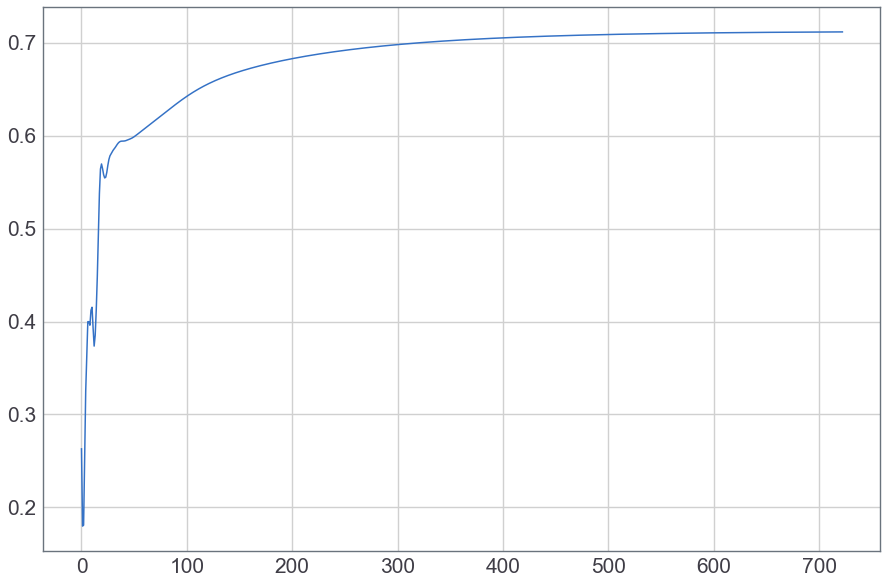

In [47]:
plot(F.sigmoid(stop_probs[0]).data.cpu().numpy())

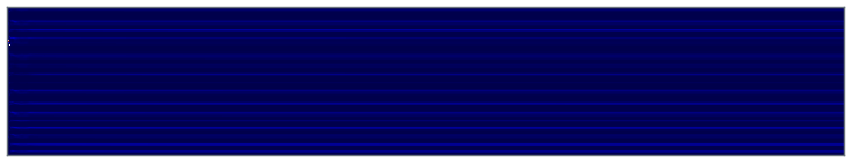

In [48]:
show_images([attn_probs[:, 0].T], pixel_range='auto', cmap='seismic')

In [49]:
_diagonality(attn_probs[:, 0].T)

0.0079045501

In [50]:
criterion_mse(post_preds, sample_spectrogram[0]).data.cpu().numpy()[0]

1.6023694

In [51]:
def similarity(x, y, mode='lin'):
    cosine = (x * y).sum(1) / (x.norm(dim=1) * y.norm(dim=1))
    if mode=='sin': return torch.sqrt((1 - cosine) / 2)
    
    angle = torch.acos(cosine)
    if mode == 'lin': return angle / np.pi
    
    mode += 1
    return mode * (1 - (1 - 1 / mode) ** (angle / np.pi))

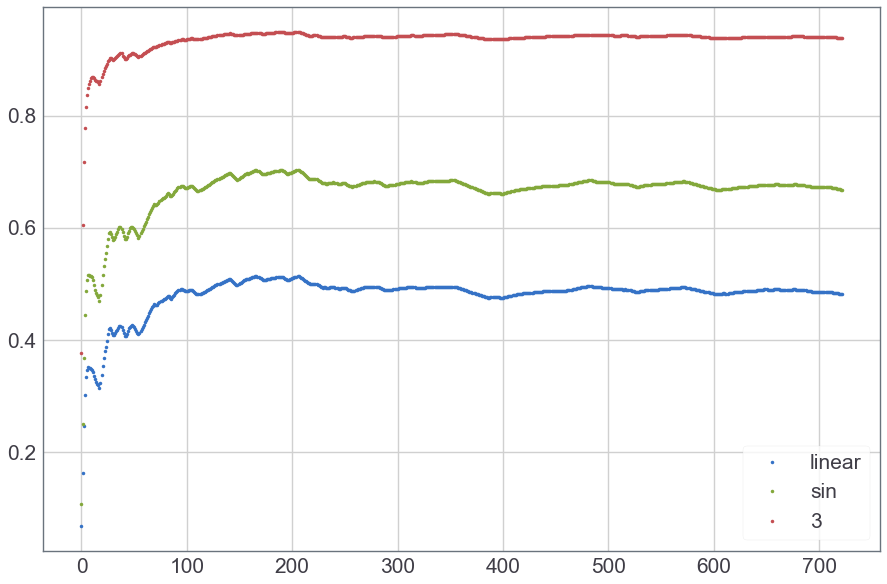

In [52]:
cummean = lambda x: np.cumsum(x) / (1 + np.arange(len(x)))

plot(cummean(similarity(post_preds, sample_spectrogram[0])[0].data.cpu().numpy()), '.', label='linear')
plot(cummean(similarity(post_preds, sample_spectrogram[0], 'sin')[0].data.cpu().numpy()), '.', label='sin')
for k in range(3,4):
    plot(cummean(similarity(post_preds, sample_spectrogram[0], 10 ** (-k))[0].data.cpu().numpy()), '.', label=str(k))
plt.legend()
plt.show()

it will continue to rely in many respects upon the greater resources of the Office of Science and Technology and other agencies.


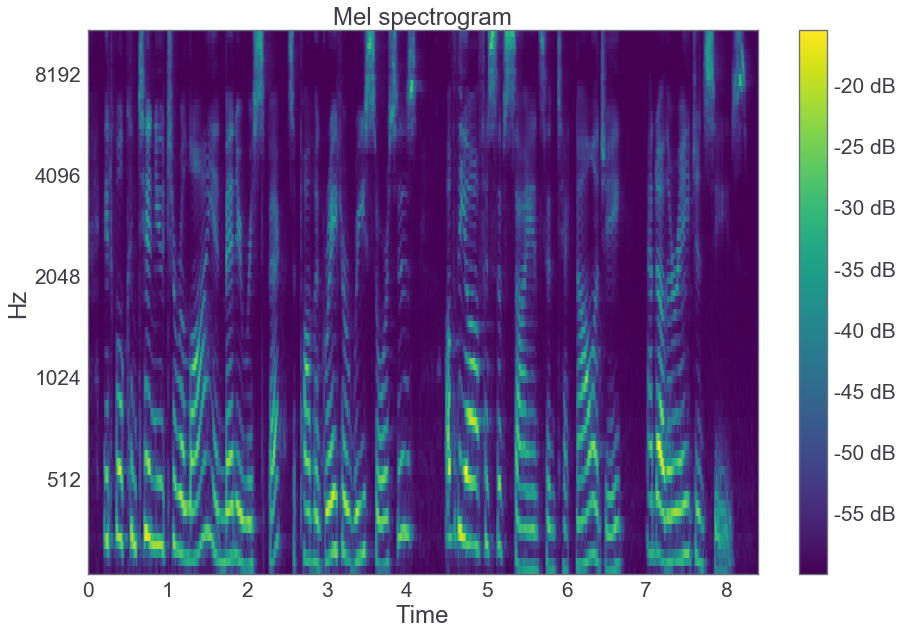

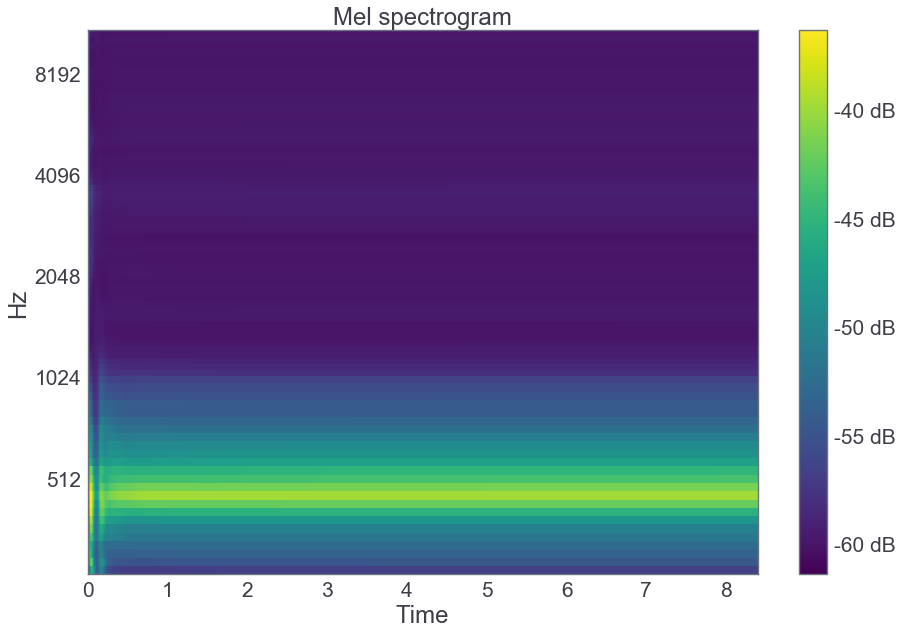

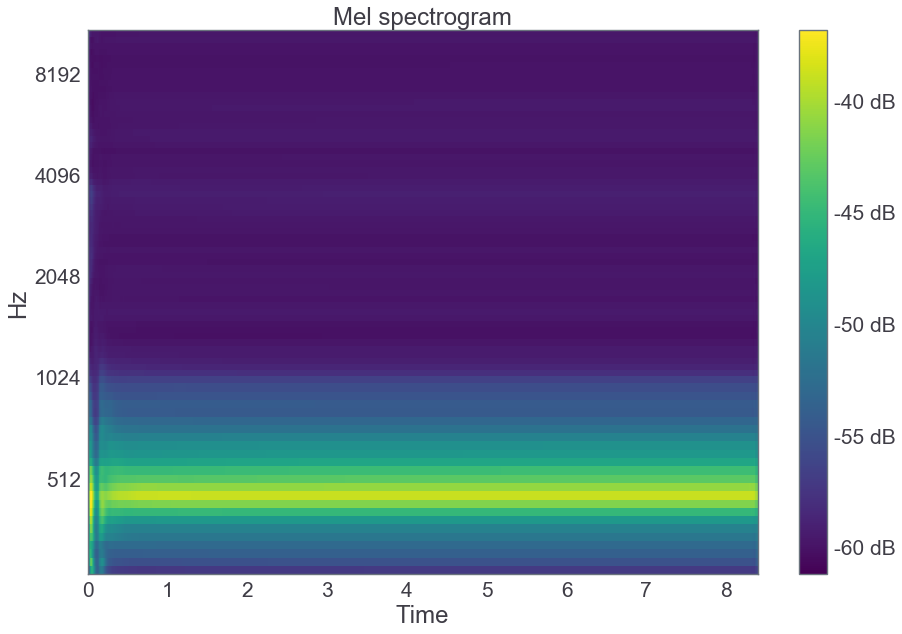

In [53]:
print(''.join(idx_char[i] for i in sample_transcript[0].data.cpu().numpy()[0]))
plot_spectrogram(sample_spectrogram[0][0].data.cpu().numpy())
plot_spectrogram(pre_preds[0].data.cpu().numpy())
plot_spectrogram(post_preds[0].data.cpu().numpy())

# Test

In [52]:
def vocode(spectrogram):
    np.save(os.path.join(DIR_OUTPUT, 'spec.npy'), spectrogram.T)
    !python ../utils/wavenet_vocoder/synthesis.py ../utils/wavenet_vocoder/checkpoints/lj.pth ../Outputs --conditional=../Outputs/spec.npy
    return wavfile.read(os.path.join(DIR_OUTPUT, 'lj.wav'))[1]

In [53]:
def test(sentence, stop_threshold=0.8, max_len=100):
    transcript = tokenizer.texts_to_sequences([sentence])
    transcript = Variable(cuda(torch.LongTensor(transcript)), volatile=True)
    spectrogram = model((transcript, [transcript.size(1)]),
                        stop_threshold=stop_threshold, max_len=max_len)[1]
    spectrogram = spectrogram[0].data.cpu().numpy()
    spectrogram = spectrogram * spec_std + spec_mean
    return vocode(spectrogram), spectrogram

In [54]:
res, spectrogram = test("Vaisakh")

Using TensorFlow backend.
100%|████████████████████████████████████| 25600/25600 [02:50<00:00, 149.82it/s]


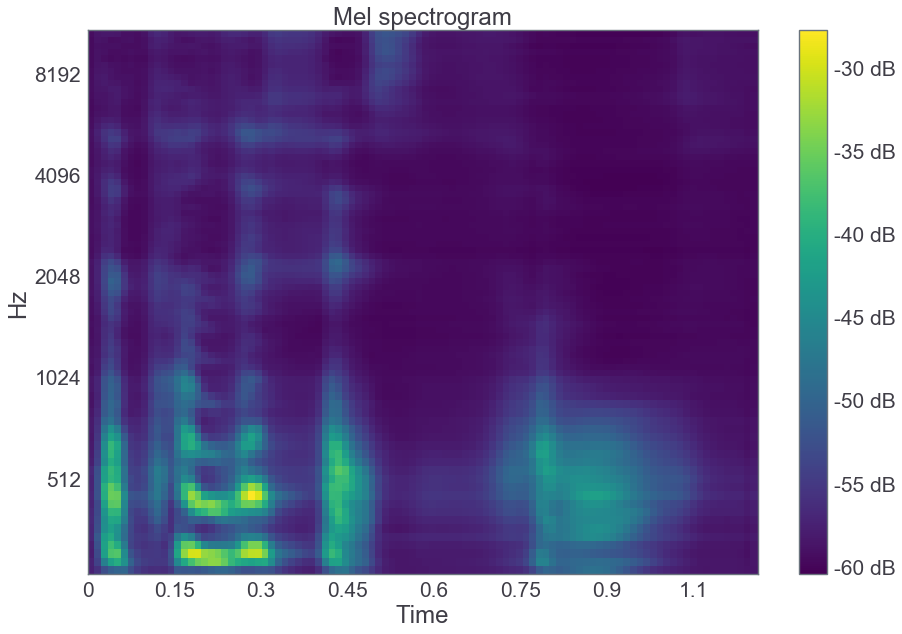

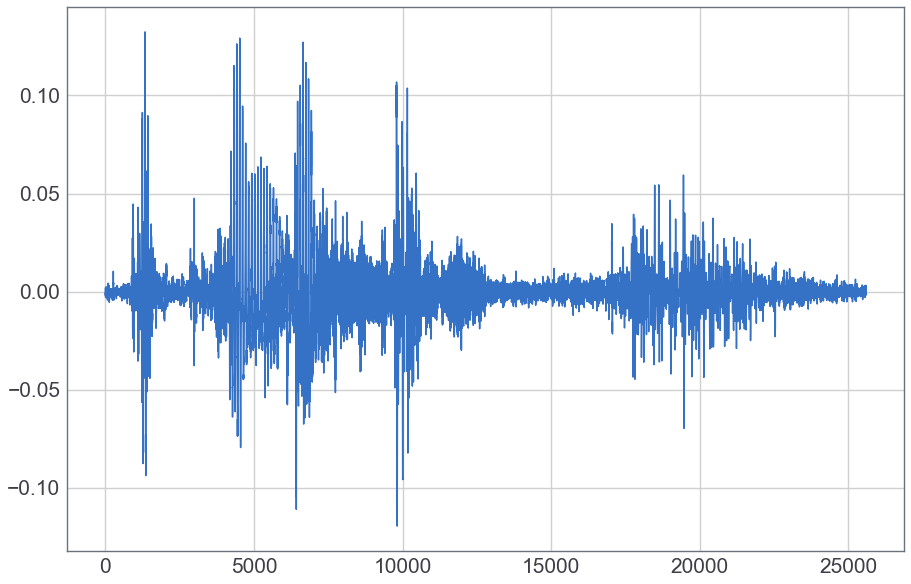

In [55]:
plot_spectrogram(normalize(spectrogram))
plot(res)
display.Audio(res, rate=hparams.sample_rate)